<a href="https://colab.research.google.com/github/mns-037/fr-plot/blob/main/Market_Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
! pip install mlxtend --upgrade --no-deps
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
! pip install -q kaggle
from google.colab import files
files.upload()

     |████████████████████████████████| 1.3 MB 28.0 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadnanda","key":"16c5ecafb770520e6d80183fb374a550"}'}

# aa

In [2]:
! mkdir ~/.kaggle
! mv ./kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mysarahmadbhat/customersegmentation
! unzip \*.zip  && rm *.zip

 84% 6.00M/7.17M [00:00<00:00, 61.3MB/s]
100% 7.17M/7.17M [00:00<00:00, 66.4MB/s]
Archive:  customersegmentation.zip
  inflating: Online Retail.csv       


In [32]:
# Read Data
data = pd.read_csv('/content/Online Retail.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [34]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Preprocessing Data

In [35]:
def my_encode(u):
    if u <= 0:
        return 0
    return 1

In [36]:
data = data[(data['Quantity']>0) &
            (data['UnitPrice']>0)
            ]
data['Description'] = data['Description'].str.strip()
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDay'] = data['InvoiceDate'].dt.day_name()
data['InvoiceHour'] = data['InvoiceDate'].dt.hour
data['InvoiceDate'] = data['InvoiceDate'].dt.date
data['TotalPrice'] = data['Quantity']*data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceHour,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,Wednesday,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,Wednesday,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,Wednesday,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,Wednesday,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,Wednesday,8,20.34


In [37]:
data.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceHour,TotalPrice
count,530104,530104,530104,530104.000000,530104,530104.000000,397884.000000,530104,530104,530104.000000,530104.000000
unique,19960,3922,4015,NaN,305,NaN,NaN,38,6,NaN,NaN
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-12-05,NaN,NaN,United Kingdom,Thursday,NaN,NaN
freq,1114,2265,2323,NaN,5297,NaN,NaN,485123,101007,NaN,NaN
mean,NaN,NaN,NaN,10.542037,NaN,3.907625,15294.423453,NaN,NaN,13.075623,20.121871
std,NaN,NaN,NaN,155.524124,NaN,35.915681,1713.141560,NaN,NaN,2.438741,270.356743
min,NaN,NaN,NaN,1.000000,NaN,0.001000,12346.000000,NaN,NaN,6.000000,0.001000
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13969.000000,NaN,NaN,11.000000,3.750000
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15159.000000,NaN,NaN,13.000000,9.900000
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16795.000000,NaN,NaN,15.000000,17.700000


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    530104 non-null  object 
 1   StockCode    530104 non-null  object 
 2   Description  530104 non-null  object 
 3   Quantity     530104 non-null  int64  
 4   InvoiceDate  530104 non-null  object 
 5   UnitPrice    530104 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      530104 non-null  object 
 8   InvoiceDay   530104 non-null  object 
 9   InvoiceHour  530104 non-null  int64  
 10  TotalPrice   530104 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 48.5+ MB


In [39]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
InvoiceDay          0
InvoiceHour         0
TotalPrice          0
dtype: int64

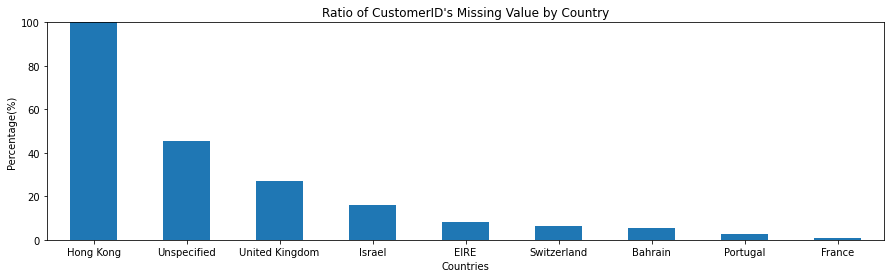

In [40]:
# countries that have missing values
mv_country = sorted(data[data['CustomerID'].isnull()]['Country'].value_counts().index)
mv_ = data[data['CustomerID'].isnull()]['Country'].value_counts().sort_index() 

non_mv = data['Country'].value_counts().sort_index()

mv_val = [mv_.loc[i] for i in mv_.index]

non_mv_val = [non_mv.loc[i] for i in non_mv.index if i in mv_country]
mv_ratio = [mv_val[i]/non_mv_val[i] for i in range(len(mv_val))]
mv_country, mv_val, non_mv_val, mv_ratio
pd.DataFrame({
    'Country':mv_country,
    'Ratio':[round(i*100,2) for i in mv_ratio]
}).set_index('Country').sort_values(['Ratio'], ascending=[False])\
                       .plot(kind='bar', 
                             title='Ratio of CustomerID\'s Missing Value by Country', 
                             figsize=(15,4), legend=False, ylim=(0,100), rot=0,
                             ylabel='Percentage(%)', xlabel='Countries'
                            )

In [41]:
data['Country'].value_counts()

United Kingdom          485123
Germany                   9040
France                    8407
EIRE                      7890
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1966
Portugal                  1501
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Unspecified                446
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     295
Hong Kong                  284
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon 

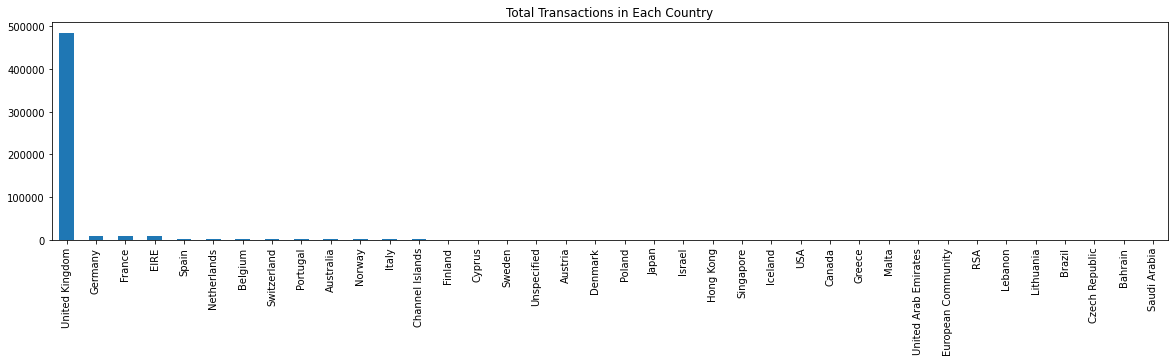

In [42]:
#@title ## **Total Transactions in Each Country**
#@markdown ---
data['Country'].value_counts().plot(kind='bar', title='Total Transactions in Each Country', figsize=(20, 4))

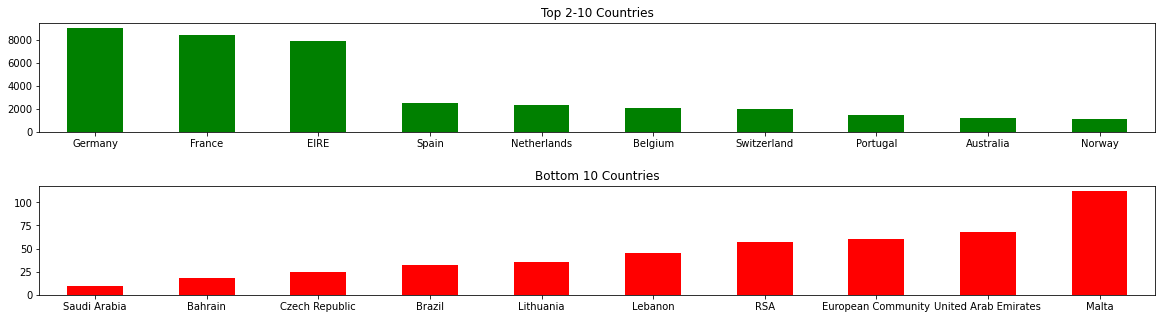

In [43]:
#@title ## **Top and Bottom Countries**
#@markdown ---

fig, axes = plt.subplots(nrows=2, figsize=(20, 5))
fig.subplots_adjust(hspace=0.5)
plt.subplot(2,1,1)
data['Country'].value_counts().iloc[1:11].plot(kind='bar', title='Top 2-10 Countries', rot=0, color='green')
plt.subplot(2,1,2)
data['Country'].value_counts().nsmallest(10).plot(kind='bar', title='Bottom 10 Countries',rot=0, color='red')

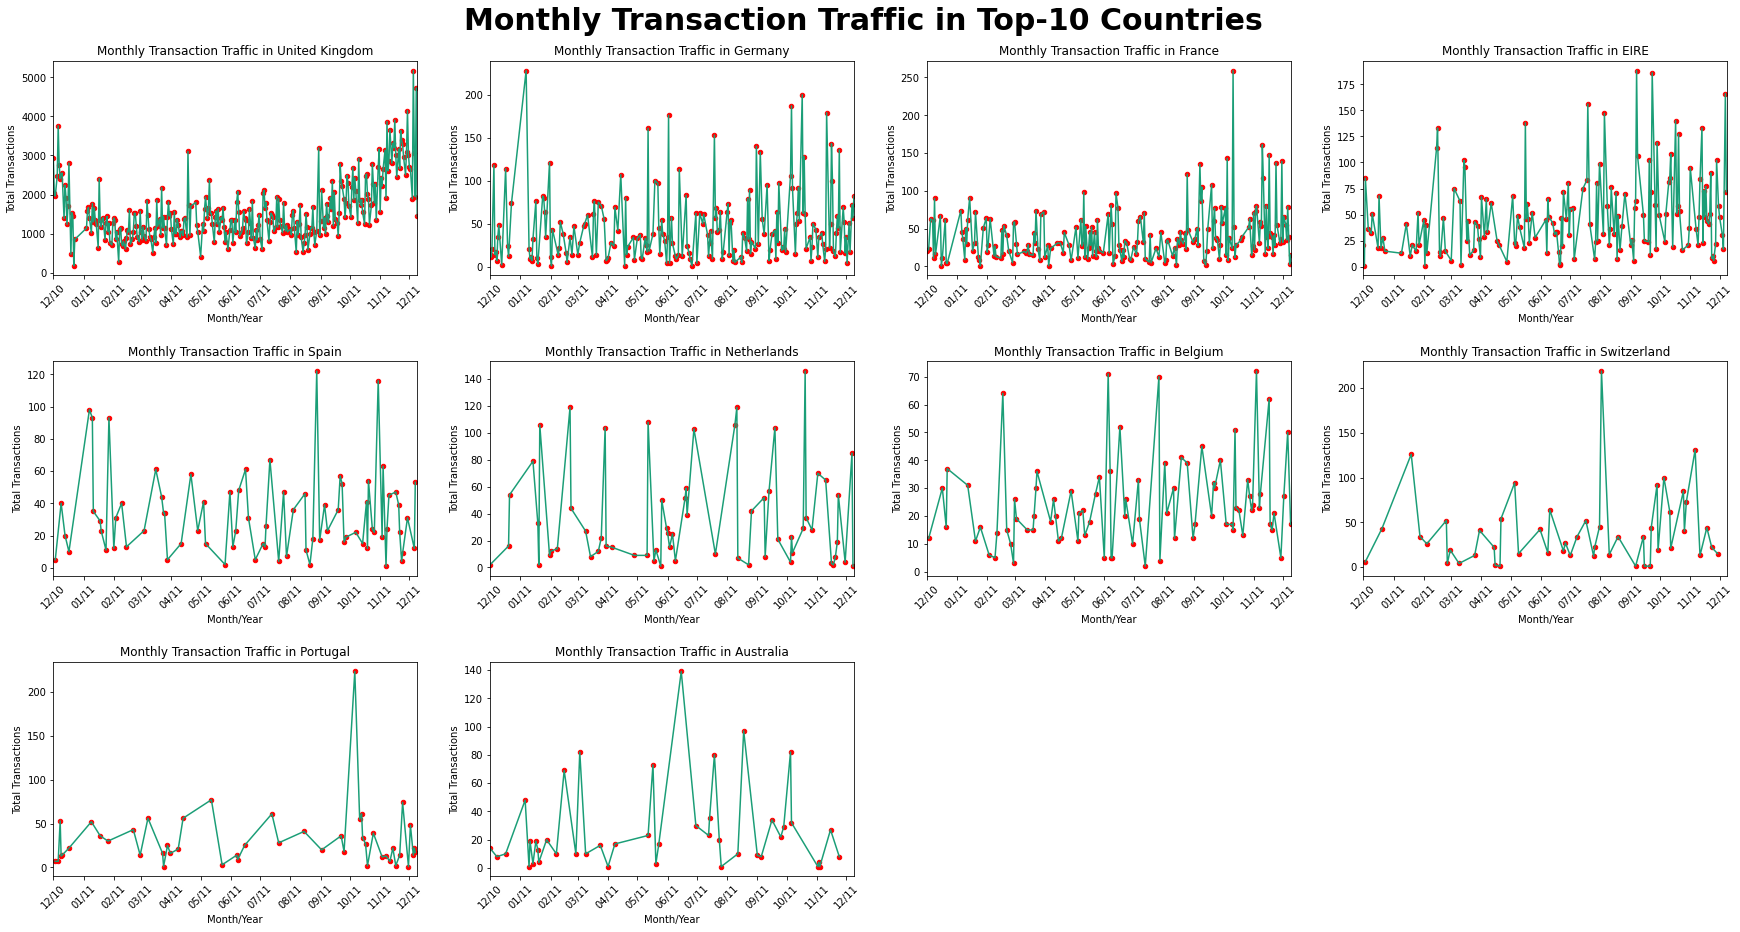

In [44]:
#@title ## **Monthly Transaction Traffic in Top-10 Countries**
#@markdown ---

fig, axes = plt.subplots(nrows=3, figsize=(30, 15))
plt.suptitle('Monthly Transaction Traffic in Top-10 Countries', fontsize=30, fontweight='bold', y=.93)
fig.subplots_adjust(hspace=0.4, wspace=0.2)
for i, cty in enumerate(data['Country'].value_counts().nlargest(10).index):
  plt.subplot(3,4,i+1)
  xticks = pd.date_range(data['InvoiceDate'].min(), data['InvoiceDate'].max(), freq='MS')
  ax = data[data['Country'] == cty][['InvoiceNo', 'InvoiceDate']]\
                                  .groupby('InvoiceDate').agg('count')\
                                  .plot(kind='line',                                        
                                        legend=False, xticks=xticks.to_pydatetime(),
                                        xlim=(data['InvoiceDate'].min(), data['InvoiceDate'].max()),
                                        colormap='Dark2',
                                        title='Monthly Transaction Traffic in '+cty,
                                        ax=plt.gca())
  dat = data[data['Country'] == cty][['InvoiceNo', 'InvoiceDate']]\
                                  .groupby('InvoiceDate').agg('count')
  dat['InvoiceDates'] = dat.index
  dat.reset_index(inplace=True)
  ax = dat.plot(kind='scatter', 
                x='InvoiceDates', y='InvoiceNo',                
                legend=False, xticks=xticks.to_pydatetime(),
                xlim=(data['InvoiceDate'].min(), data['InvoiceDate'].max()),
                c='red',
                title='Monthly Transaction Traffic in '+cty,
                ax=plt.gca())
  ax.set_xticklabels([x.strftime('%m/%y') for x in xticks])
  ax.set_xlabel('Month/Year')
  ax.set_ylabel('Total Transactions')
  plt.xticks(rotation=45);

#@markdown 

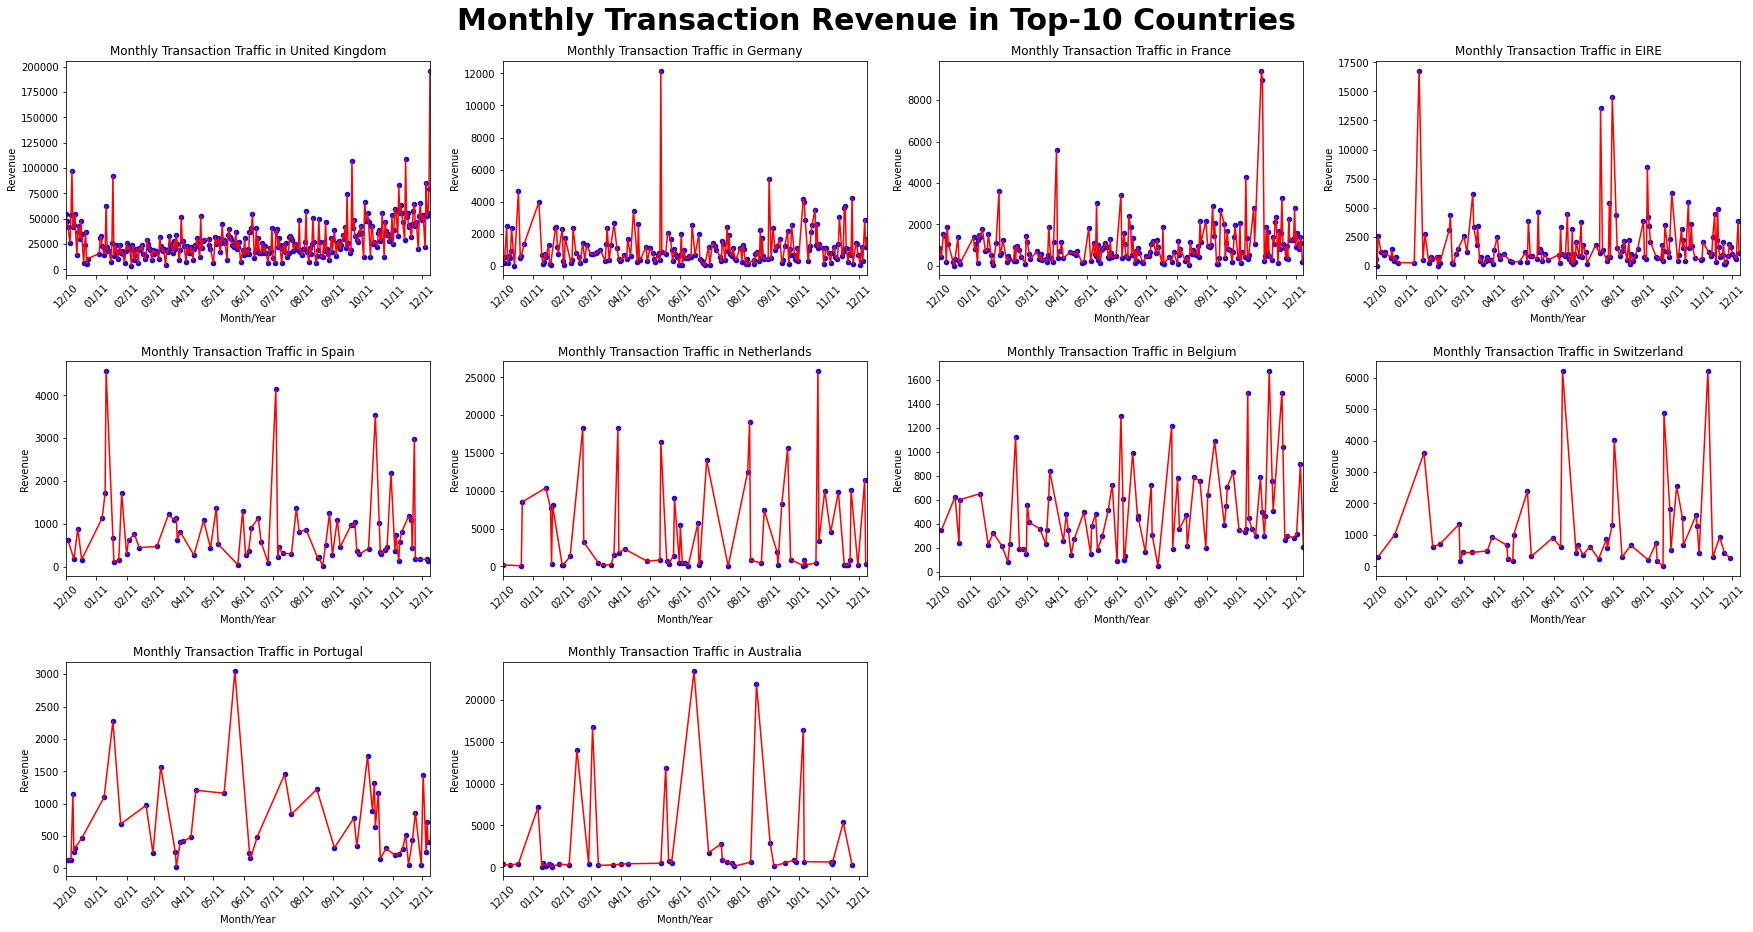

In [45]:
#@title ## **Monthly Transaction Revenue in Top-10 Countries**
#@markdown ---

fig, axes = plt.subplots(nrows=3, figsize=(30, 15))
plt.suptitle('Monthly Transaction Revenue in Top-10 Countries', fontsize=30, fontweight='bold', y=.93)
fig.subplots_adjust(hspace=0.4, wspace=0.2)
for i, cty in enumerate(data['Country'].value_counts().nlargest(10).index):
  plt.subplot(3,4,i+1)
  xticks = pd.date_range(data['InvoiceDate'].min(), data['InvoiceDate'].max(), freq='MS')
  ax = data[data['Country'] == cty][['TotalPrice', 'InvoiceDate']]\
                                  .groupby('InvoiceDate').agg('sum')\
                                  .plot(kind='line',                                        
                                        legend=False, xticks=xticks.to_pydatetime(),
                                        xlim=(data['InvoiceDate'].min(), data['InvoiceDate'].max()),
                                        color='red',
                                        title='Monthly Transaction Traffic in '+cty,
                                        ax=plt.gca())  
  dat = data[data['Country'] == cty][['TotalPrice', 'InvoiceDate']]\
                                  .groupby('InvoiceDate').agg('sum')
  dat['InvoiceDates'] = dat.index
  dat.reset_index(inplace=True)
  ax = dat.plot(kind='scatter', 
                x='InvoiceDates', y='TotalPrice',                
                legend=False, xticks=xticks.to_pydatetime(),
                xlim=(data['InvoiceDate'].min(), data['InvoiceDate'].max()),
                c='blue',
                title='Monthly Transaction Traffic in '+cty,
                ax=plt.gca())
  ax.set_xticklabels([x.strftime('%m/%y') for x in xticks])
  ax.set_xlabel('Month/Year')
  ax.set_ylabel('Revenue')
  plt.xticks(rotation=45);

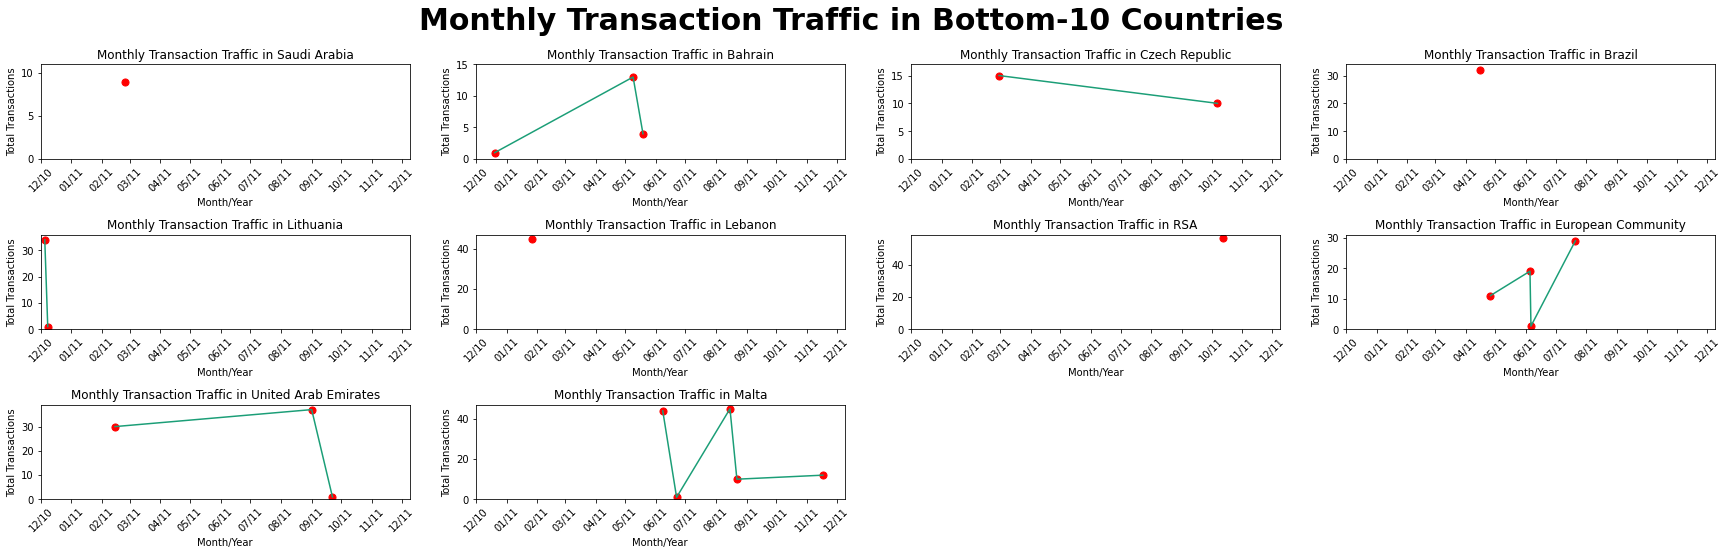

In [46]:
#@title ## **Monthly Transaction Traffic in Top-10 Countries**
#@markdown ---

fig, axes = plt.subplots(nrows=3, figsize=(30, 8))
plt.suptitle('Monthly Transaction Traffic in Bottom-10 Countries', fontsize=30, fontweight='bold')#, y=.93)
fig.subplots_adjust(hspace=0.8, wspace=0.18)
for i, cty in enumerate(data['Country'].value_counts().nsmallest(10).index):
  plt.subplot(3,4,i+1)
  xticks = pd.date_range(data['InvoiceDate'].min(), data['InvoiceDate'].max(), freq='MS')
  ax = data[data['Country'] == cty][['InvoiceNo', 'InvoiceDate']]\
                                  .groupby('InvoiceDate').agg('count')\
                                  .plot(kind='line',                                      
                                        legend=False, xticks=xticks.to_pydatetime(),
                                        xlim=(data['InvoiceDate'].min(), data['InvoiceDate'].max()),
                                        colormap='Dark2',
                                        title='Monthly Transaction Traffic in '+cty,
                                        ax=plt.gca())
  dat = data[data['Country'] == cty][['InvoiceNo', 'InvoiceDate']]\
                                  .groupby('InvoiceDate').agg('count')
  dat['InvoiceDates'] = dat.index
  dat.reset_index(inplace=True)
  ax = dat.plot(kind='scatter', s=50,
                x='InvoiceDates', y='InvoiceNo',
                ylabel='Total Transactions', xlabel='Month/Year',
                legend=False, xticks=xticks.to_pydatetime(),
                xlim=(data['InvoiceDate'].min(), data['InvoiceDate'].max()),
                ylim=(0,dat['InvoiceNo'].max()+2),
                c='red',
                title='Monthly Transaction Traffic in '+cty,
                ax=plt.gca())
  ax.set_xticklabels([x.strftime('%m/%y') for x in xticks])
  ax.set_xlabel('Month/Year')
  ax.set_ylabel('Total Transactions') 
  plt.xticks(rotation=45);

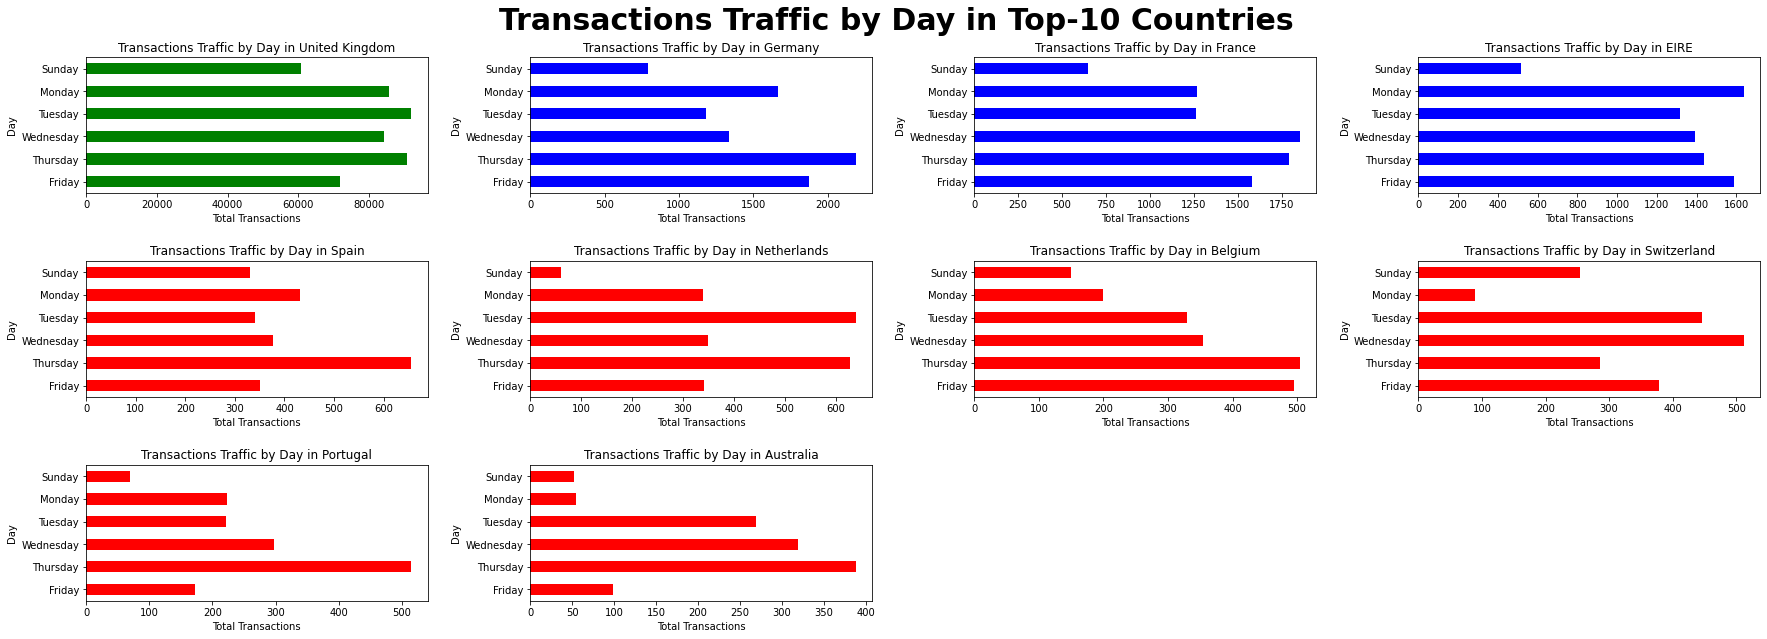

In [47]:
#@title ## **Transactions Traffic by Day in Top-10 Countries**
#@markdown ----

fig, axes = plt.subplots(nrows=3, figsize=(30, 10))
plt.suptitle('Transactions Traffic by Day in Top-10 Countries', fontsize=30, fontweight='bold', y=.95)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
cls_col = ['green']+['blue']*3+['red']*6
for i, cty in enumerate(data['Country'].value_counts().nlargest(10).index):
  plt.subplot(3,4,i+1)
  ax = data[data['Country'] == cty][['InvoiceNo', 'InvoiceDay']]\
                                  .groupby('InvoiceDay').agg('count')\
                                  .reindex(['Friday','Thursday','Wednesday','Tuesday', 'Monday', 'Sunday'])\
                                  .plot(kind='barh', rot=0,
                                          legend=False,
                                          # colormap='Dark2',
                                          color=cls_col[i],
                                          title='Transactions Traffic by Day in '+cty,
                                          ax=plt.gca())
  ax.set_xlabel('Total Transactions')
  ax.set_ylabel('Day')

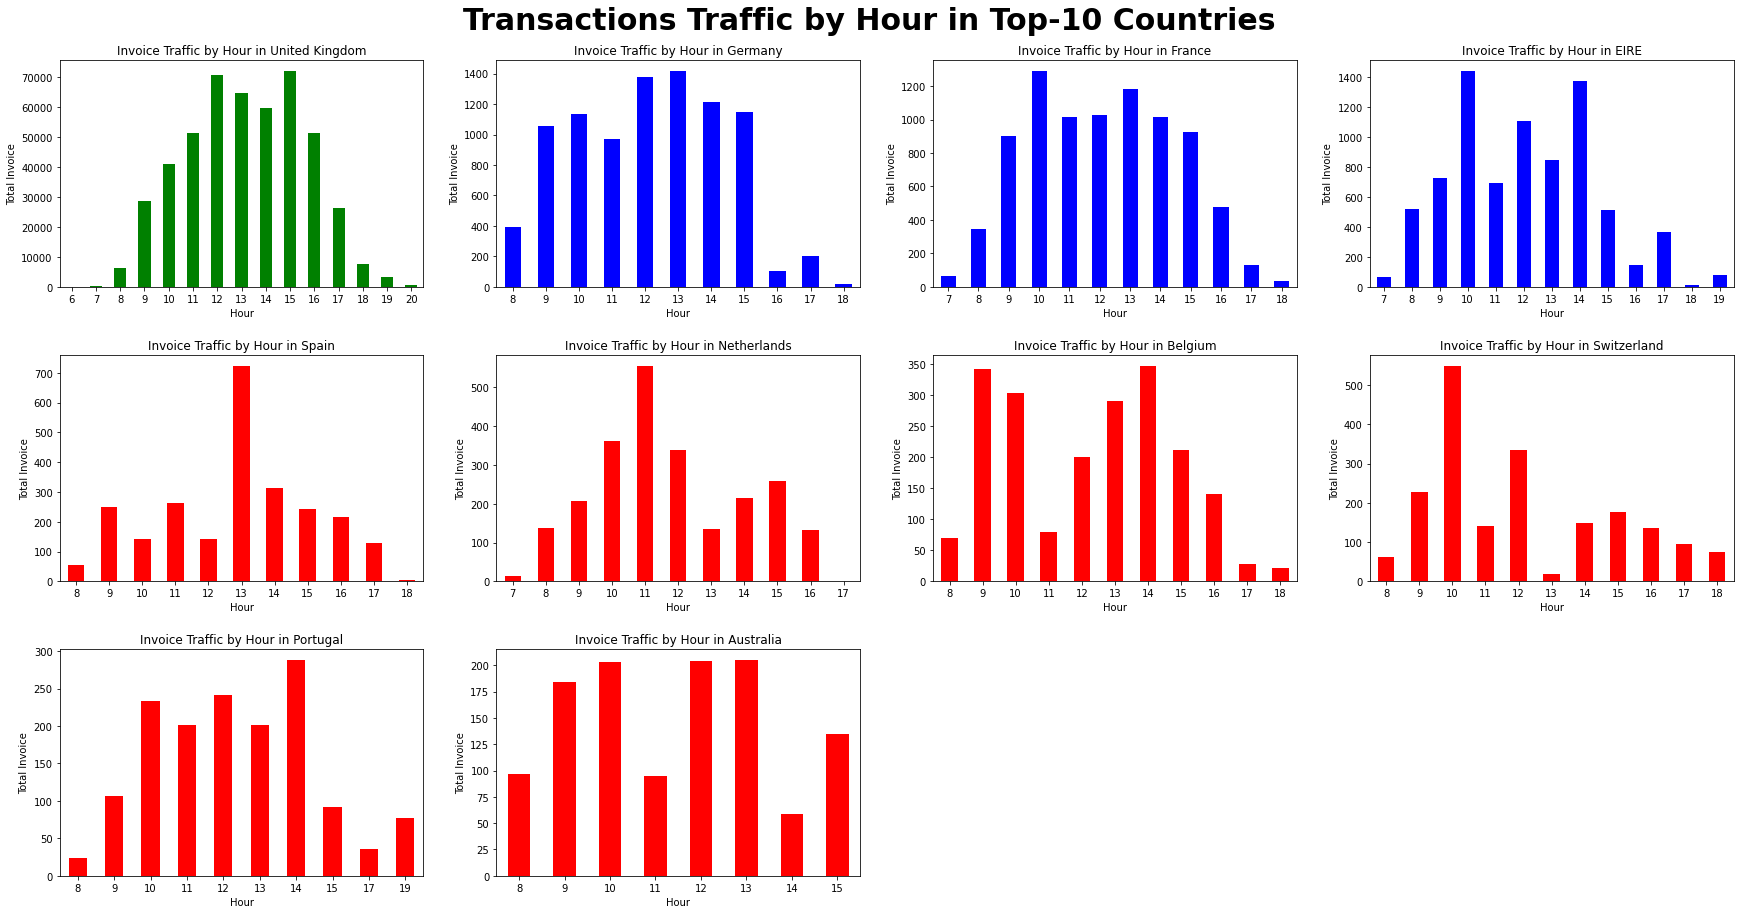

In [48]:
#@title ## **Transactions Traffic by Hour in Top-10 Countries**
#@markdown ----

fig, axes = plt.subplots(nrows=3, figsize=(30, 15))
plt.suptitle('Transactions Traffic by Hour in Top-10 Countries', fontsize=30, fontweight='bold', y=.93)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
for i, cty in enumerate(data['Country'].value_counts().nlargest(10).index):
  plt.subplot(3,4,i+1)
  data[data['Country'] == cty][['InvoiceNo', 'InvoiceHour']]\
                                  .groupby('InvoiceHour').agg('count')\
                                  .sort_index()\
                                  .plot(kind='bar', rot=0,
                                        ylabel='Total Invoice', xlabel='Hour',
                                        # xticks=[i for i in range(6,21)],
                                        xlim=(6,21),
                                        legend=False, color=cls_col[i],
                                        title='Invoice Traffic by Hour in '+cty,
                                        ax=plt.gca())

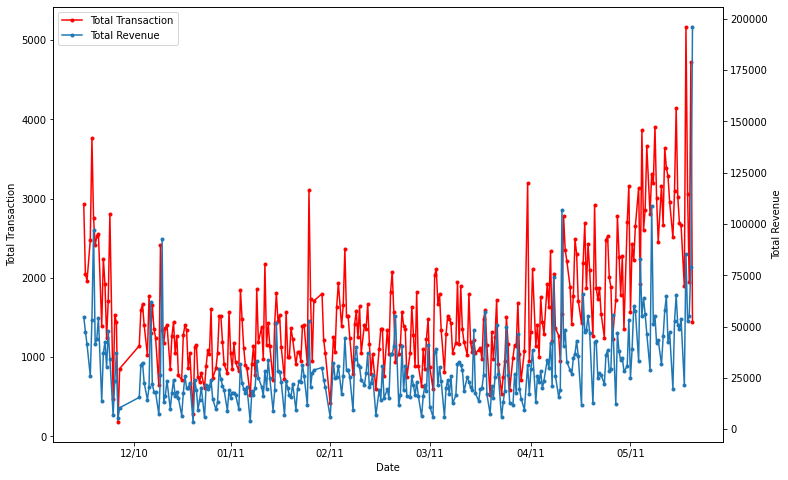

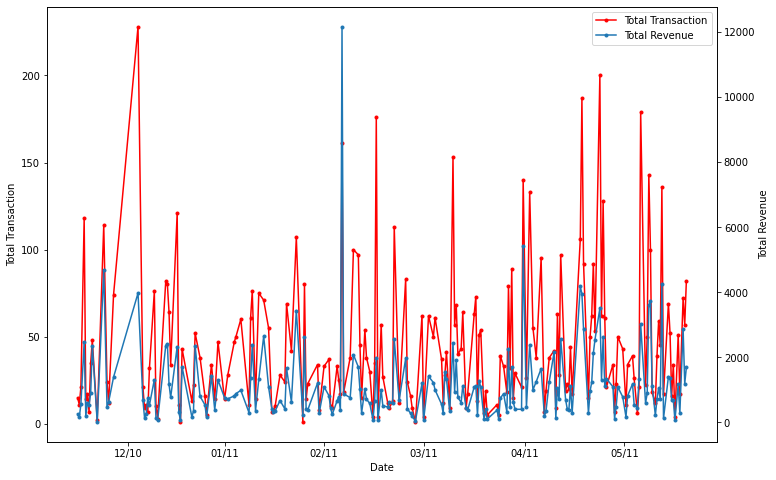

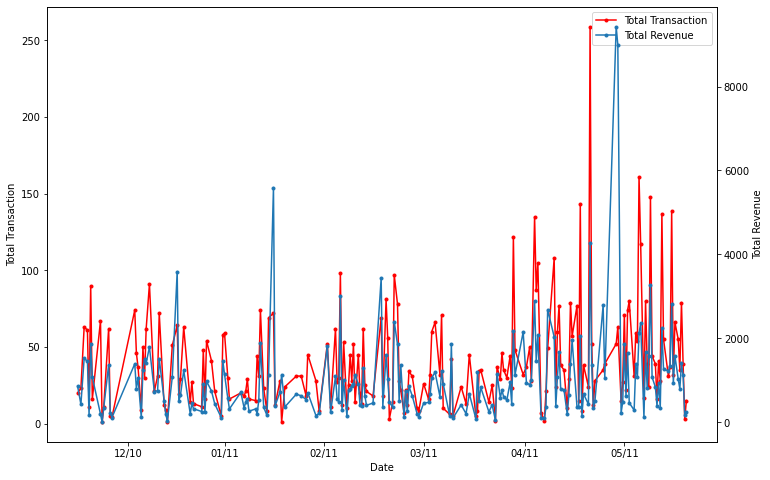

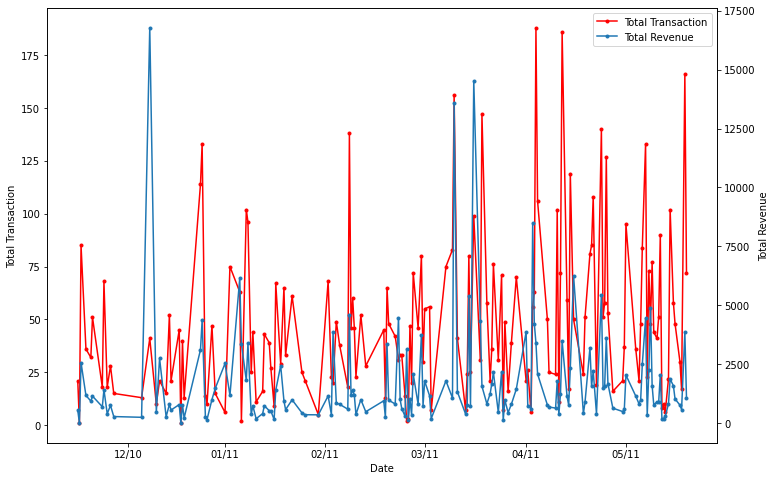

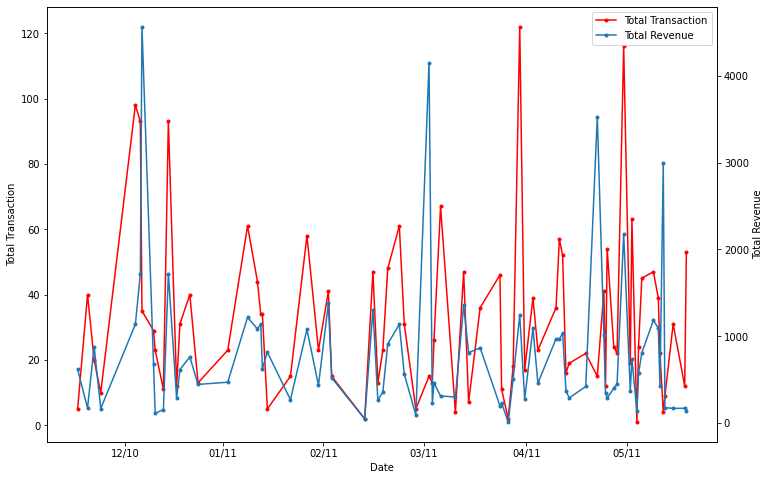

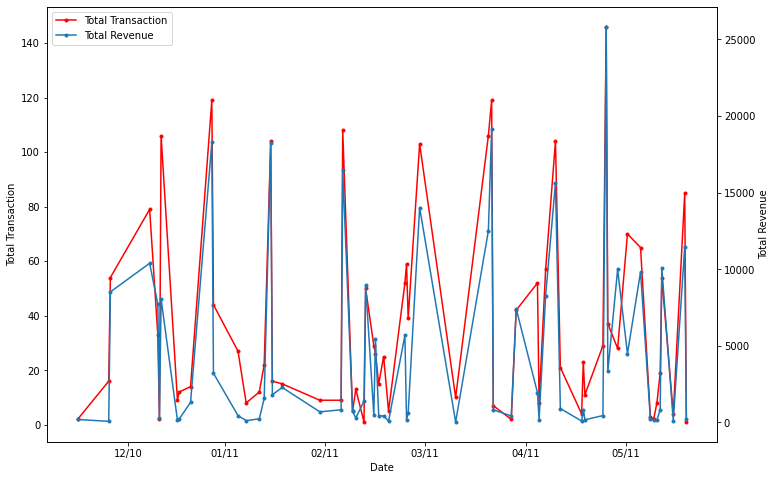

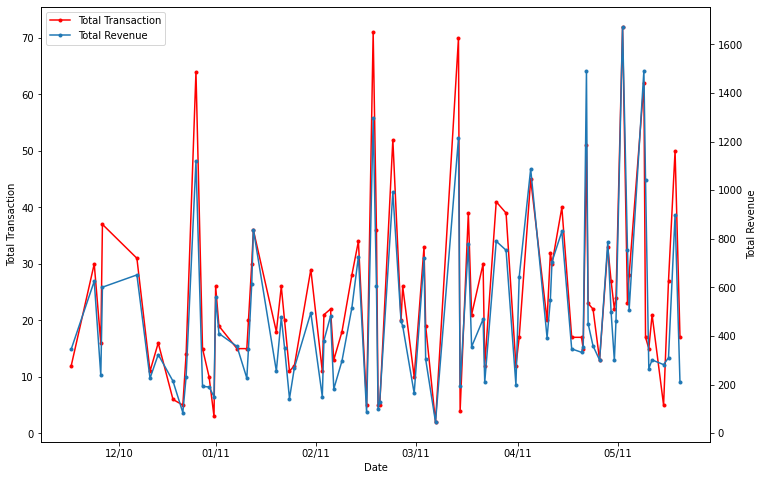

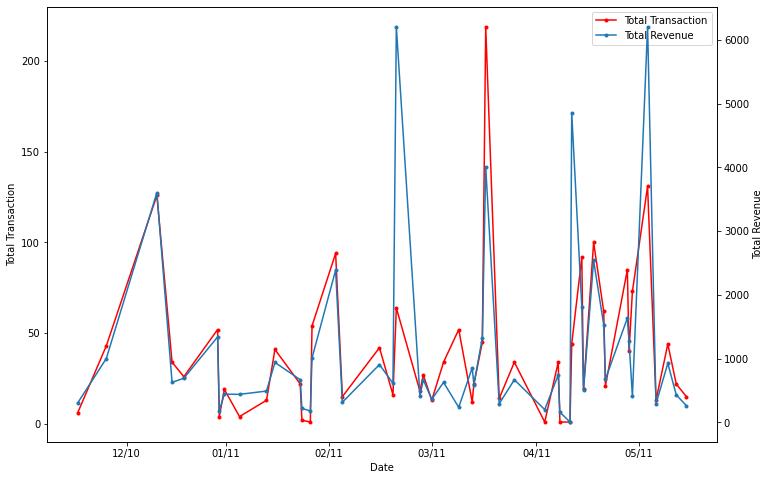

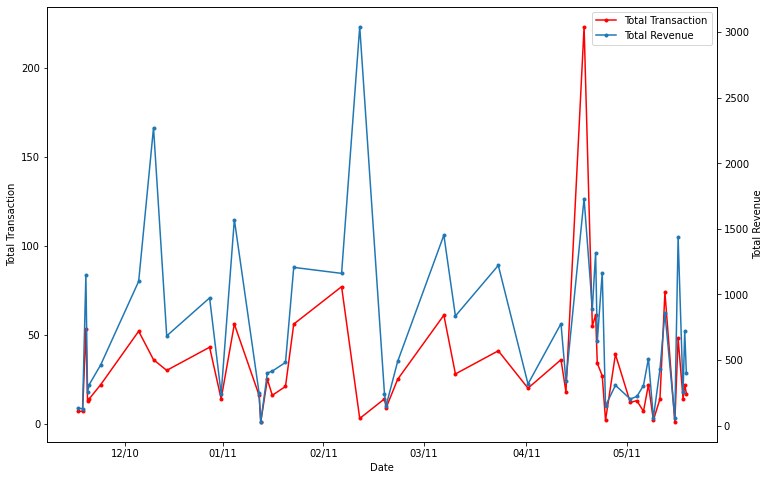

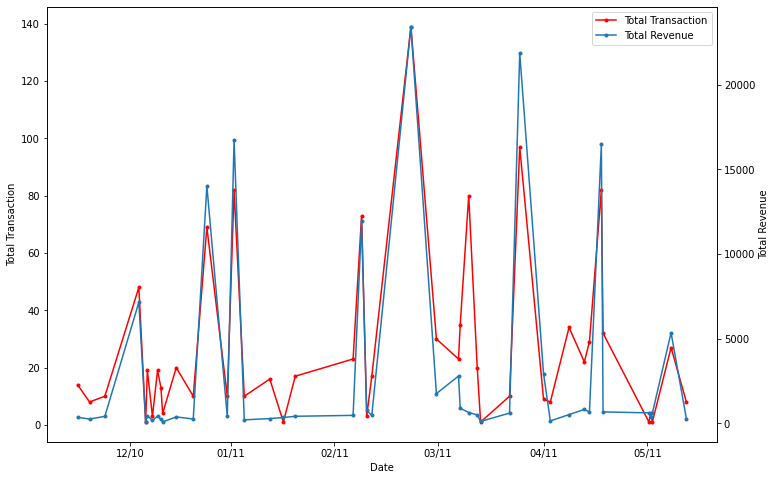

In [49]:
from mpl_toolkits.axes_grid1 import axes_grid
nrows = 3
ncols = 4
naxes = 2

# f = plt.figure(figsize=(30, 15))
# # for i, (k, m) in enumerate(zip('ABCDEFGHIJK', 'mbrygrygybr')):
# for i, cty in enumerate(data['Country'].value_counts().nlargest(10).index):  
#     ag = axes_grid.Grid(f, (nrows, ncols, i+1), (naxes, 1), axes_pad=0)
#     # for j in range(naxes):
#     dat = data[data['Country'] == 'United Kingdom'][['InvoiceNo', 'InvoiceDate', 'TotalPrice']]\
#                               .groupby('InvoiceDate').agg(['count', 'sum'])
#     dat.drop([('InvoiceNo',   'sum'), ('TotalPrice', 'count')], axis=1, inplace=True)

#     # fig, ax = plt.subplots()
#     dat.InvoiceNo.plot(kind='line', ax=ag, color='red', legend=False, marker='.')
#     ag.set_ylabel(ylabel='Total Transaction')
#     lines, labels = ag.get_legend_handles_labels()

#     ag_2 = ag.twinx()
#     coba.TotalPrice.plot(kind='line', ax=ag_2, legend=False, marker='.')
#     ag_2.set_ylabel(ylabel='Total Revenue')
#     line, label = ag_2.get_legend_handles_labels()
#     lines += line

#     ag.legend(lines, ['Total Transaction', 'Total Revenue'], loc=0)
#     ag.set_xlabel(xlabel='Date')


        # ag[j].bar(range(20), df[k][20*j: 20*(j+1)], color = m)
        # ag[j].set_ylim(0, df.max().max())
        # if i%ncols==0:
        #     if j == naxes-1:
        #         ag[j].yaxis.set_ticks([0, ag[j].get_yticks()[-1]])
        #     else:
        #         ag[j].yaxis.set_ticks([ag[j].get_yticks()[-1]])
        # else:
        #     ag[j].yaxis.set_ticks([])
        # if i in range(ncols):
        #     ag[j].xaxis.set_ticks([])

# plt.subplots_adjust(wspace=0.1, hspace=0.1)

# fig, ax = plt.subplots(nrows=3, figsize=(30, 15))
# plt.suptitle('Monthly Transaction Revenue in Top-10 Countries', fontsize=30, fontweight='bold', y=.93)
# fig.subplots_adjust(hspace=0.4, wspace=0.2)
for i, cty in enumerate(data['Country'].value_counts().nlargest(10).index):  
  # plt.subplot(3,4,i+1)
  xticks = pd.date_range(data['InvoiceDate'].min(), data['InvoiceDate'].max(), freq='MS')
  coba = data[data['Country'] == cty][['InvoiceNo', 'InvoiceDate', 'TotalPrice']]\
                                    .groupby('InvoiceDate').agg(['count', 'sum'])
  coba.drop([('InvoiceNo',   'sum'), ('TotalPrice', 'count')], axis=1, inplace=True)

  fig, ax = plt.subplots()
  coba.InvoiceNo.plot(kind='line', ax=ax, color='red', legend=False, marker='.', figsize=(12,8))
  ax.set_ylabel(ylabel='Total Transaction')
  lines, labels = ax.get_legend_handles_labels()

  ax_2 = ax.twinx()
  coba.TotalPrice.plot(kind='line', ax=ax_2, legend=False, marker='.', figsize=(12,8))
  ax_2.set_ylabel(ylabel='Total Revenue')
  line, label = ax_2.get_legend_handles_labels()
  lines += line
  ax.set_xticklabels([x.strftime('%m/%y') for x in xticks])
  ax.legend(lines, ['Total Transaction', 'Total Revenue'], loc=0)
  ax.set_xlabel(xlabel='Date')


In [50]:
# Select specific country
data_uk = data[data['Country']=='United Kingdom']
data_uk.tail(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceHour,TotalPrice
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09,1.25,13113.0,United Kingdom,Friday,12,30.0
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09,8.95,13113.0,United Kingdom,Friday,12,214.8
541893,581586,20685,DOORMAT RED RETROSPOT,10,2011-12-09,7.08,13113.0,United Kingdom,Friday,12,70.8


In [51]:
data_uk_by_invoice = (data_uk.groupby(['InvoiceNo', 'Description'])['Quantity']
                             .sum().unstack().reset_index().fillna(0)
                             .set_index('InvoiceNo'))
data_uk_by_invoice = data_uk_by_invoice.applymap(my_encode)
print(data_uk_by_invoice.shape)
data_uk_by_invoice.head(3)

(18019, 3996)


Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,...,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK CERAMIC CANDLE HOLDER,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Mining Process

In [52]:
freq_items = fpgrowth(data_uk_by_invoice, min_support=0.01, use_colnames=True)
freq_items

,support,itemsets
0,0.119984,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.024863,(KNITTED UNION FLAG HOT WATER BOTTLE)
2,0.022809,(RED WOOLLY HOTTIE WHITE HEART.)
3,0.018869,(SET 7 BABUSHKA NESTING BOXES)
4,0.016427,(WHITE METAL LANTERN)
...,...,...
2153,0.012653,"(LOVE HOT WATER BOTTLE, HOT WATER BOTTLE KEEP ..."
2154,0.014651,"(CHOCOLATE HOT WATER BOTTLE, HOT WATER BOTTLE ..."
2155,0.010544,"(HAND WARMER UNION JACK, HAND WARMER RED LOVE ..."
2156,0.011932,"(HAND WARMER RED LOVE HEART, HAND WARMER OWL D..."


In [53]:
rules = association_rules(freq_items, metric='support', min_threshold=0)
print(rules.shape)
rules

(4382, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(HAND WARMER UNION JACK),(HAND WARMER OWL DESIGN),0.026417,0.034908,0.013042,0.493697,14.142981,0.012120,1.906158
1,(HAND WARMER OWL DESIGN),(HAND WARMER UNION JACK),0.034908,0.026417,0.013042,0.373609,14.142981,0.012120,1.554274
2,(HAND WARMER UNION JACK),(HAND WARMER SCOTTY DOG DESIGN),0.026417,0.029746,0.011876,0.449580,15.113767,0.011091,1.762751
3,(HAND WARMER SCOTTY DOG DESIGN),(HAND WARMER UNION JACK),0.029746,0.026417,0.011876,0.399254,15.113767,0.011091,1.620623
4,(HAND WARMER UNION JACK),(HAND WARMER BIRD DESIGN),0.026417,0.029857,0.010267,0.388655,13.017068,0.009478,1.586900
...,...,...,...,...,...,...,...,...,...
4377,(HAND WARMER RED LOVE HEART),(HAND WARMER UNION JACK),0.021422,0.026417,0.010544,0.492228,18.633311,0.009979,1.917363
4378,(HAND WARMER RED LOVE HEART),(HAND WARMER OWL DESIGN),0.021422,0.034908,0.011932,0.556995,15.956263,0.011184,2.178513
4379,(HAND WARMER OWL DESIGN),(HAND WARMER RED LOVE HEART),0.034908,0.021422,0.011932,0.341812,15.956263,0.011184,1.486777
4380,(HAND WARMER SCOTTY DOG DESIGN),(HAND WARMER RED LOVE HEART),0.029746,0.021422,0.010822,0.363806,16.982953,0.010185,1.538176


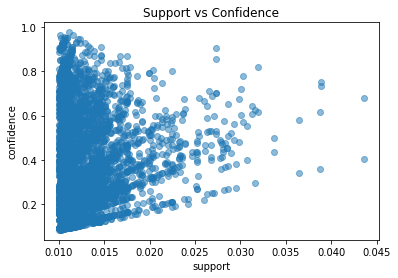

In [54]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

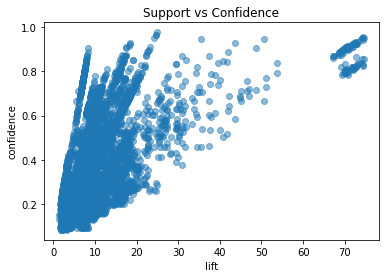

In [55]:
plt.scatter(rules['lift'], rules['confidence'], alpha=0.5)
plt.xlabel('lift')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

## Cluster

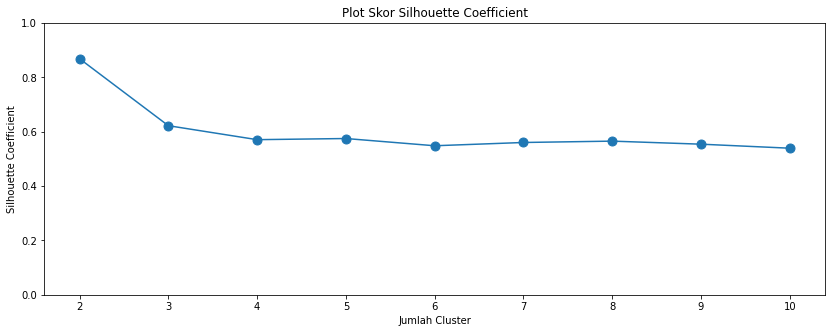

k terbaik: 2, skor: 0.8684935035560456


In [56]:
# list nilai silhouette coefficients untuk tiap k
silhouette_coef_ = []
best = 0
index = 0

kmeans_kwargs = {
    'init': 'random',
    'n_init': 10,
    'tol':1e-5,
    'max_iter': 100,
    'random_state': 42,
}

# k dimulai dari 2
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(rules[['confidence', 'lift', 'support']])
    score = silhouette_score(rules[['confidence', 'lift', 'support']], kmeans.labels_)
    silhouette_coef_.append(score)
    if score > best:
      best = score
      index = k

plt.figure(figsize=(14, 5))
plt.title('Plot Skor Silhouette Coefficient')
plt.plot(range(2, 11), silhouette_coef_, marker='.', markersize=18)
plt.xticks(range(2, 11))
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Coefficient')
plt.ylim(0,1)
plt.show()
print('k terbaik: {}, skor: {}'.format(index,best))

In [57]:
kmeans_rules = KMeans(n_clusters=index, **kmeans_kwargs) #pickle-in
kmeans_rules.fit(rules[['confidence', 'lift', 'support']])# Predict the cluster from the data and save it 
cluster = kmeans_rules.predict(rules[['confidence', 'lift', 'support']])# Add to the dataframe and show the result
rules['cluster'] = cluster
rules
# pickle.dump(kmeans_alasan, open('kmeans_alasan.pkl', 'wb'))
# data_hasil.sample(7)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,cluster
0,(HAND WARMER UNION JACK),(HAND WARMER OWL DESIGN),0.026417,0.034908,0.013042,0.493697,14.142981,0.012120,1.906158,1
1,(HAND WARMER OWL DESIGN),(HAND WARMER UNION JACK),0.034908,0.026417,0.013042,0.373609,14.142981,0.012120,1.554274,1
2,(HAND WARMER UNION JACK),(HAND WARMER SCOTTY DOG DESIGN),0.026417,0.029746,0.011876,0.449580,15.113767,0.011091,1.762751,1
3,(HAND WARMER SCOTTY DOG DESIGN),(HAND WARMER UNION JACK),0.029746,0.026417,0.011876,0.399254,15.113767,0.011091,1.620623,1
4,(HAND WARMER UNION JACK),(HAND WARMER BIRD DESIGN),0.026417,0.029857,0.010267,0.388655,13.017068,0.009478,1.586900,1
...,...,...,...,...,...,...,...,...,...,...
4377,(HAND WARMER RED LOVE HEART),(HAND WARMER UNION JACK),0.021422,0.026417,0.010544,0.492228,18.633311,0.009979,1.917363,1
4378,(HAND WARMER RED LOVE HEART),(HAND WARMER OWL DESIGN),0.021422,0.034908,0.011932,0.556995,15.956263,0.011184,2.178513,1
4379,(HAND WARMER OWL DESIGN),(HAND WARMER RED LOVE HEART),0.034908,0.021422,0.011932,0.341812,15.956263,0.011184,1.486777,1
4380,(HAND WARMER SCOTTY DOG DESIGN),(HAND WARMER RED LOVE HEART),0.029746,0.021422,0.010822,0.363806,16.982953,0.010185,1.538176,1


In [58]:
rules[(rules['cluster']==0)].sort_values(['support', 'confidence', 'lift'], ascending=[False, False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,cluster
4239,(REGENCY TEA PLATE GREEN),(REGENCY TEA PLATE ROSES),0.018647,0.021144,0.015595,0.836310,39.552392,0.015200,5.979918,0
4238,(REGENCY TEA PLATE ROSES),(REGENCY TEA PLATE GREEN),0.021144,0.018647,0.015595,0.737533,39.552392,0.015200,3.738955,0
4246,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN),0.014762,0.018647,0.013375,0.906015,48.587753,0.013100,10.441596,0
4247,(REGENCY TEA PLATE GREEN),(REGENCY TEA PLATE PINK),0.018647,0.014762,0.013375,0.717262,48.587753,0.013100,3.484631,0
4248,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE ROSES),0.014762,0.021144,0.013097,0.887218,41.960058,0.012785,8.679187,0
...,...,...,...,...,...,...,...,...,...,...
1861,"(HERB MARKER BASIL, HERB MARKER MINT)",(HERB MARKER THYME),0.011210,0.012764,0.010100,0.900990,70.586698,0.009957,9.971081,0
1862,"(HERB MARKER THYME, HERB MARKER BASIL)",(HERB MARKER MINT),0.011266,0.012931,0.010100,0.896552,69.334616,0.009955,9.541669,0
1864,(HERB MARKER THYME),"(HERB MARKER BASIL, HERB MARKER MINT)",0.012764,0.011210,0.010100,0.791304,70.586698,0.009957,4.737950,0
1865,(HERB MARKER BASIL),"(HERB MARKER THYME, HERB MARKER MINT)",0.012875,0.011099,0.010100,0.784483,70.677974,0.009958,4.588499,0


In [59]:
import plotly.express as px
fig = px.scatter_3d(rules, x='support', y='lift', z='confidence',
              color='cluster')
fig.show()

In [60]:
aa  

encoder = TransactionEncoder().fit(data_te) #data_uk_by_invoice['Description'].to_list())
onehot = encoder.transform(data_te)
onehot = pd.DataFrame(onehot, columns=encoder.columns_)
onehot

NameError: ignored

#### TES


In [ ]:
tes = pd.read_csv('https://assets.datacamp.com/production/repositories/5654/datasets/5a3bc2ebccb77684a6d8a9f3fbec23fe04d4e3aa/online_retail.csv')
tes['Description'] = tes['Description'].str.strip()
tes['Quantity'] = [1] * tes.shape[0]
tes_by_invoice = (tes.groupby(['InvoiceNo', 'Description'])['Quantity']
                             .sum().unstack().reset_index().fillna(0)
                             .set_index('InvoiceNo'))
tes_by_invoice = tes_by_invoice.applymap(my_encode)
print(tes_by_invoice.shape)
tes_by_invoice.head(3)

In [ ]:
tes_freq_items = fpgrowth(tes_by_invoice, min_support=0.01, use_colnames=True)
print(tes_freq_items.head())
tes_rules = association_rules(tes_freq_items, metric='support', min_threshold=0)
print(tes_rules.shape)
rules

In [ ]:
# list nilai silhouette coefficients untuk tiap k
silhouette_coef_ = []
best = 0
index = 0

kmeans_kwargs = {
    'init': 'random',
    'n_init': 10,
    'tol':1e-5,
    'max_iter': 100,
    'random_state': 42,
}

# k dimulai dari 2
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(tes_rules[['confidence', 'lift', 'support']])
    score = silhouette_score(tes_rules[['confidence', 'lift', 'support']], kmeans.labels_)
    silhouette_coef_.append(score)
    if score > best:
      best = score
      index = k

plt.figure(figsize=(14, 5))
plt.title('Plot Skor Silhouette Coefficient')
plt.plot(range(2, 11), silhouette_coef_, marker='.', markersize=18)
plt.xticks(range(2, 11))
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Coefficient')
plt.ylim(0,1)
plt.show()
print('k terbaik: {}, skor: {}'.format(index,best))

In [ ]:
kmeans_rules = KMeans(n_clusters=index, **kmeans_kwargs) #pickle-in
kmeans_rules.fit(tes_rules[['confidence', 'lift', 'support']])# Predict the cluster from the data and save it 
cluster = kmeans_rules.predict(tes_rules[['confidence', 'lift', 'support']])# Add to the dataframe and show the result
tes_rules['cluster'] = cluster
tes_rules

In [ ]:
fig = px.scatter_3d(tes_rules, x='support', y='lift', z='confidence',
              color='cluster')
fig.show()

# Lain-lain

In [ ]:
# get the right format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Get date only
data['Date'] = data['InvoiceDate'].dt.date

# get the day
data['Day'] = data['InvoiceDate'].dt.day_name()

# data['Day Category'] = data['Day'].apply(, axis=1)
data.info()

In [ ]:
data.tail()

In [ ]:
data['Day'].value_counts()

In [ ]:
data['date'].min(), data['date'].max()

In [ ]:
data_by_customer = data[['CustomerID','Description']].groupby('CustomerID').agg(lambda x: x.tolist())
data_by_invoice = data[['InvoiceNo','Description']].groupby('InvoiceNo').agg(lambda x: x.tolist())
data_by_invoice.head(), data_by_customer.head()

In [ ]:
data_by_customer.shape

#### Note:

- Market Basket Analysis
- Visualisasi
- Per negara(?)
- Per Hari Tertentu(?)


In [ ]:
for item in data.columns:
  print(item, len(data[item].unique()))